In [ ]:
!pip install --upgrade xgboost -qq

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [ ]:
sheet_id = "19_PDN8T2OjMV49tQTTblBPPtt6C_9oWg-yeSjqRYjFA"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [ ]:
prices = df['price_inr'].values
dates = df['date'].values

In [ ]:
def create_lag_features(series, n_lags=10):
    df_lag = pd.DataFrame()
    for i in range(1, n_lags+1):
        df_lag[f'lag_{i}'] = series.shift(i)
    df_lag['target'] = series
    df_lag = df_lag.dropna().reset_index(drop=True)
    return df_lag

n_lags = 10
df_lag = create_lag_features(df['price_inr'], n_lags)
X = df_lag.drop('target', axis=1).values
y = df_lag['target'].values

In [ ]:
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.03,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'min_child_weight': 3,
    'seed': 42
}


evals = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

[0]	train-rmse:10427.90704	eval-rmse:11667.83685
[1]	train-rmse:10135.57278	eval-rmse:11365.02998
[2]	train-rmse:9852.87400	eval-rmse:11064.58303
[3]	train-rmse:9576.76759	eval-rmse:10770.95528
[4]	train-rmse:9308.29739	eval-rmse:10495.71680
[5]	train-rmse:9048.81449	eval-rmse:10230.47966
[6]	train-rmse:8796.49565	eval-rmse:9971.13597
[7]	train-rmse:8551.64917	eval-rmse:9712.20487
[8]	train-rmse:8316.27229	eval-rmse:9462.04744
[9]	train-rmse:8084.79075	eval-rmse:9217.72894
[10]	train-rmse:7859.41575	eval-rmse:8979.45030
[11]	train-rmse:7645.42274	eval-rmse:8755.89004
[12]	train-rmse:7436.38224	eval-rmse:8539.77578
[13]	train-rmse:7232.80419	eval-rmse:8323.31287
[14]	train-rmse:7038.94881	eval-rmse:8117.15766
[15]	train-rmse:6848.92725	eval-rmse:7918.05711
[16]	train-rmse:6666.00942	eval-rmse:7721.68143
[17]	train-rmse:6485.89713	eval-rmse:7540.59512
[18]	train-rmse:6312.02634	eval-rmse:7358.26384
[19]	train-rmse:6144.85010	eval-rmse:7177.81279
[20]	train-rmse:5982.11641	eval-rmse:7003.

In [ ]:
y_train_pred = xgb_model.predict(dtrain)
y_test_pred = xgb_model.predict(dtest)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

In [ ]:
print(f"Train RMSE: {train_rmse:.2f}, R2: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")

Train RMSE: 1196.95, R2: 0.99
Test RMSE: 1840.07, R2: 0.59


In [ ]:
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
mae = np.mean(np.abs(y_test - y_test_pred))

In [ ]:
inr_to_thb = 0.44
mae_thb = mae * inr_to_thb

print(f"Average Error (%): {mape:.2f}%")
print(f"Average Error: {mae:.2f} INR / {mae_thb:.2f} THB")

Average Error (%): 2.90%
Average Error: 1463.40 INR / 643.90 THB


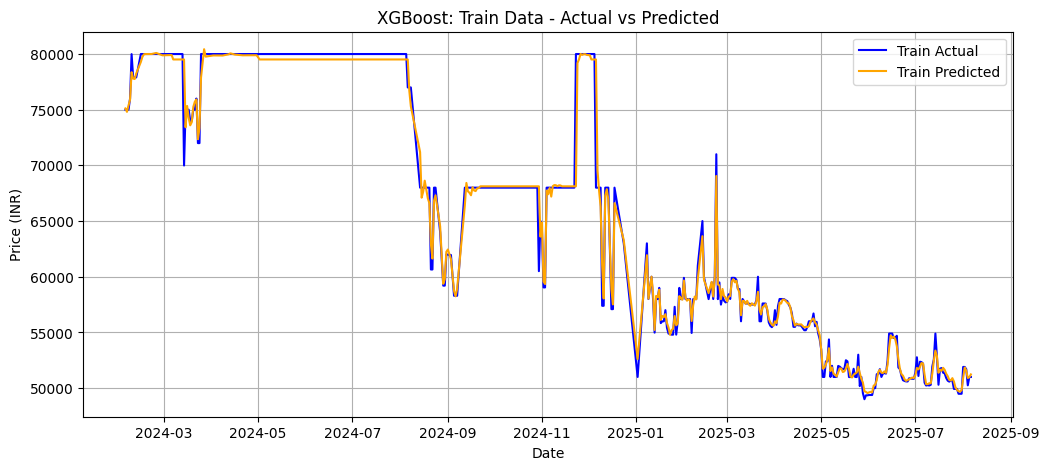

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dates[n_lags:split+n_lags], y_train, label='Train Actual', color='blue')
plt.plot(dates[n_lags:split+n_lags], y_train_pred, label='Train Predicted', color='orange')
plt.title("XGBoost: Train Data - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.show()

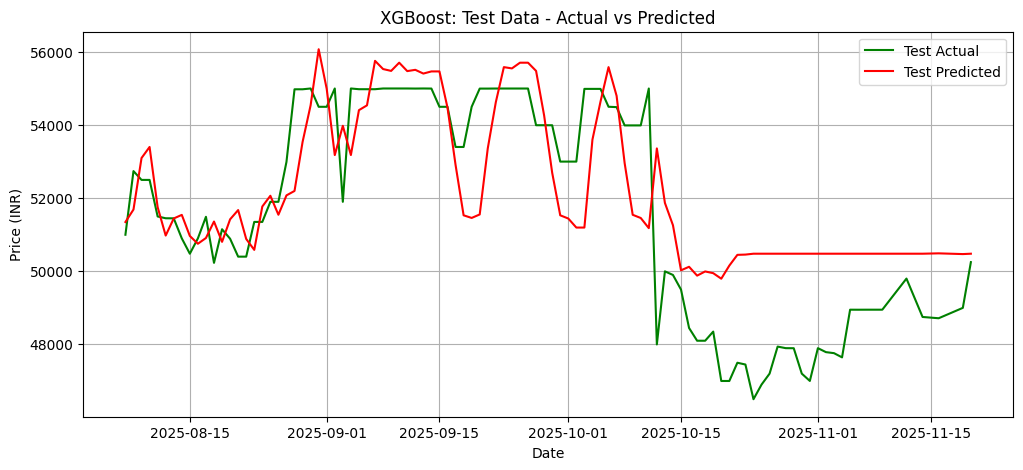

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dates[split+n_lags:], y_test, label='Test Actual', color='green')
plt.plot(dates[split+n_lags:], y_test_pred, label='Test Predicted', color='red')
plt.title("XGBoost: Test Data - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.show()

## **--- แบบเพิ่ม Feature-based Cleaning + smoothing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
sheet_id = "19_PDN8T2OjMV49tQTTblBPPtt6C_9oWg-yeSjqRYjFA"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [ ]:
prices = df['price_inr'].values
dates = df['date'].values

In [ ]:
n_lags = 10
df_feat = pd.DataFrame()
for i in range(1, n_lags+1):
    df_feat[f'lag_{i}'] = df['price_inr'].shift(i)

In [ ]:
df_feat['rolling_mean_3'] = df['price_inr'].rolling(window=3).mean().shift(1)
df_feat['rolling_std_3'] = df['price_inr'].rolling(window=3).std().shift(1)

df_feat['day_of_week'] = df['date'].dt.dayofweek
df_feat['month'] = df['date'].dt.month

df_feat['target'] = df['price_inr']

df_feat = df_feat.dropna().reset_index(drop=True)

In [ ]:
X = df_feat.drop('target', axis=1).values
y = df_feat['target'].values

split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.03,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'min_child_weight': 3,
    'seed': 42
}

evals = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

[0]	train-rmse:10425.89993	eval-rmse:11659.21692
[1]	train-rmse:10132.71552	eval-rmse:11342.17780
[2]	train-rmse:9852.01512	eval-rmse:11038.97268
[3]	train-rmse:9574.79403	eval-rmse:10747.31978
[4]	train-rmse:9304.92793	eval-rmse:10462.92509
[5]	train-rmse:9044.12679	eval-rmse:10186.46302
[6]	train-rmse:8790.03027	eval-rmse:9950.24050
[7]	train-rmse:8544.08592	eval-rmse:9692.34863
[8]	train-rmse:8306.83161	eval-rmse:9436.48469
[9]	train-rmse:8076.37756	eval-rmse:9191.83068
[10]	train-rmse:7848.97206	eval-rmse:9002.01774
[11]	train-rmse:7634.30181	eval-rmse:8772.74318
[12]	train-rmse:7424.20609	eval-rmse:8549.40691
[13]	train-rmse:7220.59774	eval-rmse:8333.27329
[14]	train-rmse:7024.71265	eval-rmse:8164.56719
[15]	train-rmse:6833.25084	eval-rmse:7961.96141
[16]	train-rmse:6648.29256	eval-rmse:7765.48567
[17]	train-rmse:6466.67119	eval-rmse:7576.74197
[18]	train-rmse:6292.22492	eval-rmse:7391.36694
[19]	train-rmse:6123.88669	eval-rmse:7211.88435
[20]	train-rmse:5959.36812	eval-rmse:7037.

In [ ]:
y_train_pred = xgb_model.predict(dtrain)
y_test_pred = xgb_model.predict(dtest)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, R2: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")

mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
mae = np.mean(np.abs(y_test - y_test_pred))
inr_to_thb = 0.44
mae_thb = mae * inr_to_thb
print(f"Average Error (%): {mape:.2f}%")
print(f"Average Error: {mae:.2f} INR / {mae_thb:.2f} THB")

Train RMSE: 1000.23, R2: 0.99
Test RMSE: 2057.09, R2: 0.49
Average Error (%): 3.35%
Average Error: 1708.56 INR / 751.77 THB


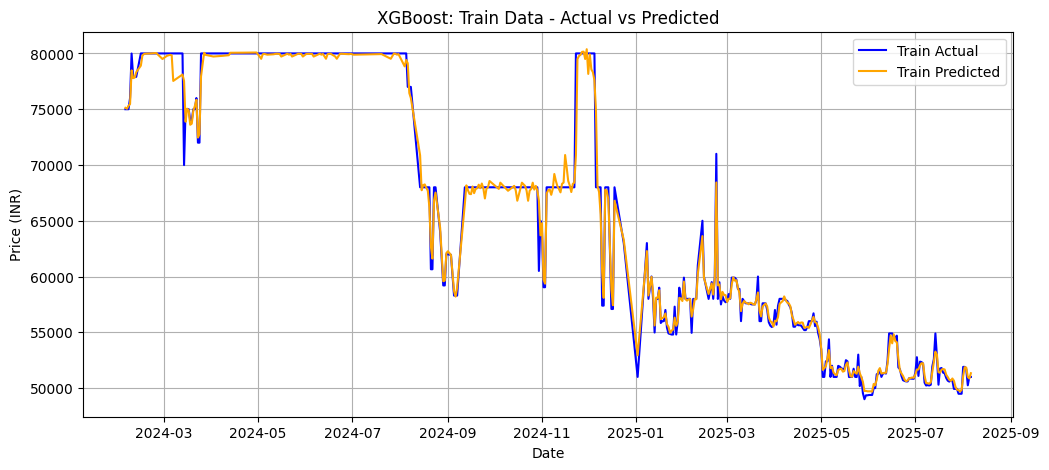

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dates[n_lags:split+n_lags], y_train, label='Train Actual', color='blue')
plt.plot(dates[n_lags:split+n_lags], y_train_pred, label='Train Predicted', color='orange')
plt.title("XGBoost: Train Data - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.show()

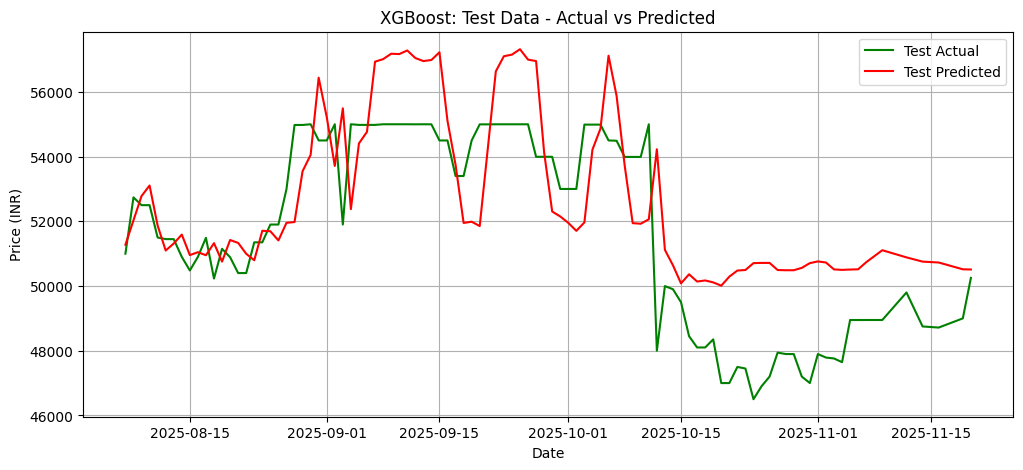

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dates[split+n_lags:], y_test, label='Test Actual', color='green')
plt.plot(dates[split+n_lags:], y_test_pred, label='Test Predicted', color='red')
plt.title("XGBoost: Test Data - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.show()